In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_01b import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [3]:
#show_install(True)

## Load Data

In [4]:
nsets = ['train', 'tier3']

In [5]:
SOURCE = Path('data')

In [6]:
fnames = []
for n in nsets:
    paths = pre_img_fpaths(get_image_files(SOURCE/n/'images'))
    fnames.extend(paths)

In [7]:
lbl_names = [img2bmask_fpath(o) for o in fnames]

In [8]:
len(fnames), fnames[:3]

(9168,
 [PosixPath('data/train/images/socal-fire_00001272_pre_disaster.png'),
  PosixPath('data/train/images/mexico-earthquake_00000125_pre_disaster.png'),
  PosixPath('data/train/images/socal-fire_00000301_pre_disaster.png')])

Note that if your mask is already like small values like 1, 2, 3, etc., instead of 255, etc., don't set `div` to True when loading the masks, as this zeroes everything.  See here:

In [9]:
# step-by-step
fname = lbl_names[-11]
PIL.Image.open(fname)
PIL.Image.open(fname).convert('L')

pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).sum()
#pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).div(255.).sum()


tensor(0)

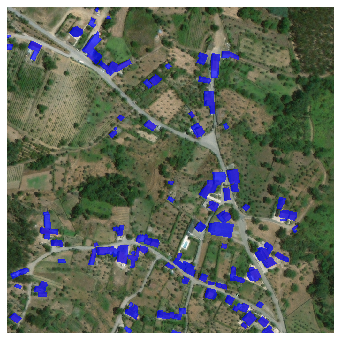

In [10]:
img_f = fnames[-5]
img = open_image(img_f)
mask = open_mask(img2bmask_fpath(img_f))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
img.show(ax=ax)
(mask).show(ax=ax, alpha=.7, cmap=CMAP, vmax=4)

## Make DataBunch

In [11]:
size = 1024
bs = 2

In [12]:
codes = np.array(['Empty', 'Building'])

In [13]:
#export
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [14]:
#export
def get_random_val_idx(n, val_pct=.1):
    return np.random.permutation(n)[:int(val_pct * n)]

In [15]:
val_idx = get_random_val_idx(len(fnames))

In [16]:
src = (SegItemListCustom(fnames)
       .split_by_idx(val_idx)
       .label_from_func(img2bmask_fpath, classes=codes))

In [17]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

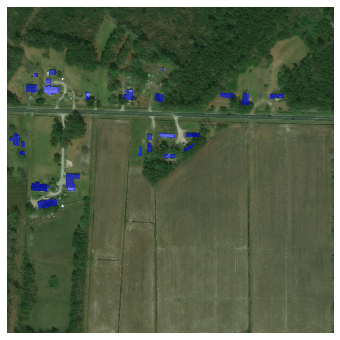

In [18]:
idx = 7
_, ax = plt.subplots(figsize=(6, 6))
data.train_ds.x[idx].show(ax)
data.train_ds.y[idx].show(ax, alpha=.5, cmap=CMAP, vmax=4)

In [25]:
data.train_ds.x[5].data.mean(), data.train_ds.x[5].data.std()

(tensor(0.2587), tensor(0.1034))

In [26]:
data.train_ds.y[5].data.unique()

tensor([0])

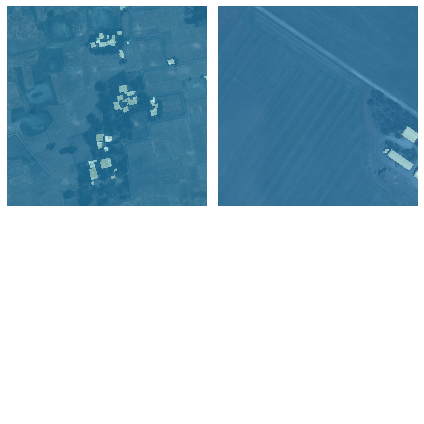

In [28]:
data.show_batch(2, figsize=(6, 6), alpha=.7)

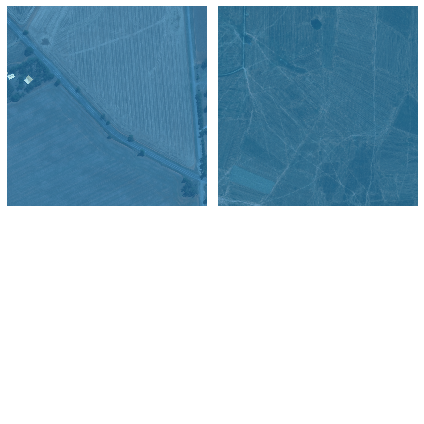

In [29]:
data.show_batch(2, figsize=(6, 6), ds_type=DatasetType.Valid, alpha=.7)

In [30]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

## Normalization

In [23]:
data.train_ds.x[6].data.mean()

tensor(0.2823)

In [24]:
data.train_ds.y[6].data.unique()

tensor([0, 1])

In [25]:
xb, yb = next(iter(data.train_dl))

In [26]:
xb.min(), xb.max(), xb.mean(), xb.std()

(tensor(-2.1179, device='cuda:0'),
 tensor(2.6400, device='cuda:0'),
 tensor(-0.8172, device='cuda:0'),
 tensor(0.6079, device='cuda:0'))

In [27]:
del xb, yb

## Custom Loss

In [19]:
#export
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)


In [20]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()


In [21]:
metrics = [dice_loss, accuracy_thresh, dice]

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [23]:
learn.loss_func = combo_loss

In [24]:
learn.load('sz1024_bs2_resnet34_8epochcycle_stage5');

In [25]:
learn.export('sz1024_bs2_resnet34_8epochcycle_stage5.pkl');

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


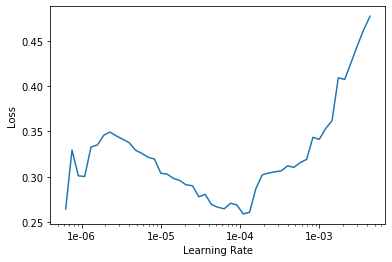

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(cyc_len=8, max_lr=slice(1e-6,3e-5))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.241947,0.251451,0.221134,0.988319,0.805530,1:02:53
1,0.258131,0.260637,0.229019,0.988151,0.797169,1:02:54
2,0.259754,0.248923,0.219569,0.988590,0.809331,1:02:55
3,0.263289,0.269612,0.237137,0.987602,0.794523,1:02:55
4,0.265304,0.240518,0.211570,0.988830,0.818615,1:02:54
5,0.268694,0.256124,0.224743,0.988250,0.805194,1:02:55
6,0.253971,0.244741,0.215043,0.988753,0.814198,1:03:00
7,0.250811,0.245424,0.216068,0.988746,0.814088,1:03:01


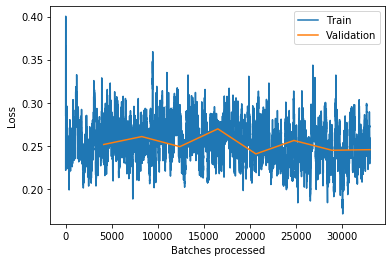

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('sz1024_bs2_resnet34_8epochcycle_stage4');

In [91]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.259021,0.260118,0.231748,0.989048,0.811136,1:03:00


In [92]:
learn.save(f'sz1024_bs2_resnet34_1epochcycle_maxlr1e-3_stage3')
learn.load(f'sz1024_bs2_resnet34_1epochcycle_maxlr1e-3_stage3');

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


## Predict batch and look at results

In [93]:
learn.model.eval();

In [94]:
learn.model.training

False

In [96]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid, )

In [97]:
outputs.shape

torch.Size([2, 2, 1024, 1024])

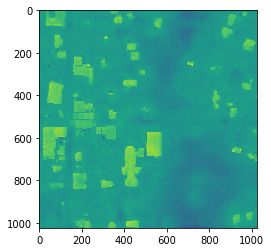

In [98]:
plt.imshow(outputs[1][1].numpy());

In [99]:
#export
def pred2mask(pred):
    return (pred[:,1,None].sigmoid() > .95).long()

In [100]:
predmask = pred2mask(outputs)

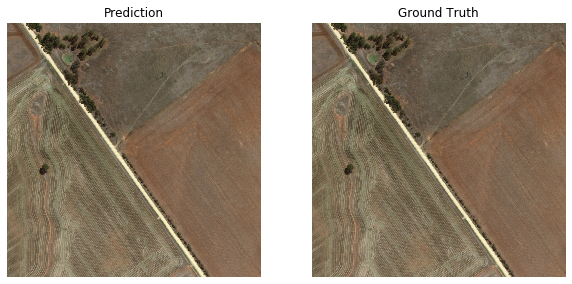

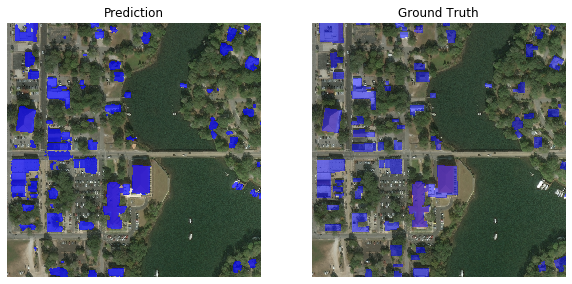

In [101]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    ax1.set_title('Prediction')
    data.valid_ds.x[i].show(ax=ax1)
    ax1.imshow(predmask[i,0], alpha=0.7, cmap=CMAP, vmax=4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.5, cmap=CMAP, vmax=4)

In [102]:
! nvidia-smi

Tue Dec 24 02:48:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    34W / 250W |  14651MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Predict on test sample(s)

In [103]:
SRC_TEST = Path('data/test')
SRC_TEST.ls()

[PosixPath('data/test/images')]

In [104]:
fnames = get_image_files(SRC_TEST/'images')
npreimgs = pre_img_fpaths(fnames)
len(npreimgs), len(fnames)

(933, 1866)

In [110]:
idx = 564

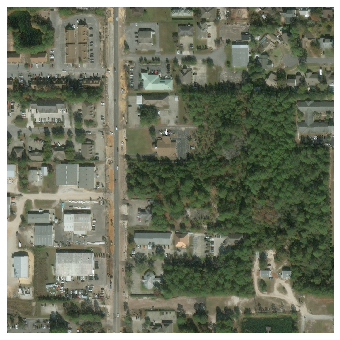

In [111]:
preimg = open_image(npreimgs[idx])
preimg.show(figsize=(6, 6))

In [112]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [113]:
y, pred, raw_pred = learn.predict(preimg)

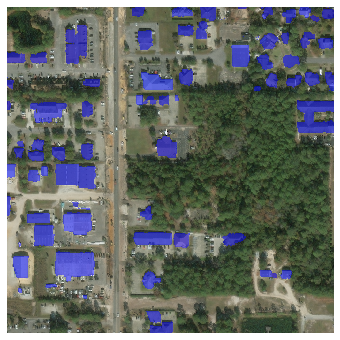

In [114]:
_, ax = plt.subplots(figsize=(6, 6))
preimg.show(ax)
y.show(ax, alpha=.5, cmap=CMAP, vmax=4)

In [56]:
! nvidia-smi

Wed Dec 18 07:52:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    31W / 250W |   7489MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# -fin

In [1]:
! python notebook2script.py 02b_segment_features.ipynb

Converted 02b_segment_features.ipynb to xview2comp/nb_02b.py
